## Analyze A/B Test Results

This project covers the statistics topics covered in the Udacity Data Analyst Nano-Degree. It covers different topics like probability, hypothesis testing and regression.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
(df.loc[df['landing_page']=='new_page']['group']!='treatment').sum()+(df.loc[df['group']=='treatment']['landing_page']!='new_page').sum()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.
**The Answer is:** We should drop these rows

In [9]:
expression = ((df['group']=='treatment')&(df['landing_page']=='new_page')|((df['group']=='control') & (df['landing_page']=='old_page')))
df2 = df.loc[expression == True]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2['user_id'].loc[df2['user_id'].duplicated()].values

array([773192], dtype=int64)

c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.loc[(df2['user_id'].duplicated())==False]

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.loc[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.loc[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2['landing_page'].loc[df2['landing_page']=='new_page'])/len(df2['landing_page'])

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The Answer.** <br>
The calculated results in steps from a. through d. represent sample statistics. They values are not sufficient to draw conclusions about population parameters. Thus, further statistical inference needs to be performed to ensure that the statistics truly represent the actual status of the population and is not caused by chance.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$H_0:  p_{new} - p_{old} \le 0$$


$$H_1: p_{new} - p_{old} \gt 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = len(df2['group'].loc[df2['landing_page']=='new_page'])
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = len(df2['group'].loc[df2['landing_page']=='old_page'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1],n_new,p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1],n_old,p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean()-old_page_converted.mean()

-0.0010071503903728435

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],n_new,p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1],n_old,p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

p_diffs = np.array(p_diffs)   

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

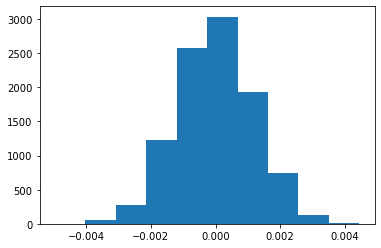

In [27]:
plt.hist(p_diffs);

**Distribution Description**<br>
This plot represent the sampling distribution of difference in sample proportions. With adequate sample size (10000), this distribution should exhibit a normal distribution according to the central limit theorm

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = df2.loc[df2['group']=='treatment']['converted'].mean() - df2.loc[df2['group']=='control']['converted'].mean()
(p_diffs > obs_diff).mean()

0.9062

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**<br>
**The Answer**<br>
The computed value is referred as p-value. P-value is the conditional propability of observing the sample statistic or one more extreme in favor of the alternative hypothesis if the null hypothesis is true.<br>
Thus while considering our null hypothesis true, there is a 90.2% to observe the observed difference in the conversion rate. with type-1 error threshold limited to 5%, we will fail to reject the null hypothesis. This means that the new page conversion rate for the new page is less than or equal the conversion rate of the old page. The company should not keep the new page as it will be committing type-1 error.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = len(df2['user_id'].loc[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2['user_id'].loc[(df2['landing_page']=='new_page')&(df2['converted']==1)])
n_old = len(df2['user_id'].loc[(df2['landing_page']=='old_page')])
n_new = len(df2['user_id'].loc[(df2['landing_page']=='new_page')])

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
zstat, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],value=0,alternative = 'larger')
zstat, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**<br>
**The Answer is**<br>
$$z-score = \frac{\hat{p_1}-\hat{p_2}}{\sqrt{p*(1-p)*(\frac{1}{n_1}+\frac{1}{n_2})}}$$<br>

The above equation represents the equation for computing z-score for a z-test using two groups. $\hat{p_1}$ and $\hat{p_2}$ represents the proportions of each group. $n_1$ and $n_2$ represents the number of samples in each group. $p$ is the proportion of the two groups added togeather.<br>
The calculated value of z-score (-1.31) can be calculated using the above equation and the calculated proportions in part I in steps (4.a.) through (4.c.) above. It shows that the observed proportions (conversion rate) of the `treatment` group is less than proportion of the `control` group.<br>
The null hypothesis set in the code above states that the difference between the proportions of the `new_page` group is same as the proportions of `old_page` group. The alternative hypothesis is that the `new_page` group has higher proportion. The high p-value states that we should not reject the null hypothesis. The result is the same calculated in Part II in step (2.j.). The subtle difference may be justified with the randomness associated with creating the null-hypothesis sampling distribution.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**<br>
**The Answer**<br>
The regression type is logistic regression to predict either the user will convert or will not convert

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

**Note to Reviewer** 
In the dummy variable creation, I didn't use the built-in function intentionally as it is easier, for me, to use a `lambda` experssion for this case.

In [31]:
df2['intercept']=1
df2['ab_page']=df2['group'].apply(lambda x: 1 if x == 'treatment' else 0)

In [32]:
#check if the intercept and dummy variable columns are added
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
LRM = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = LRM.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        14:05:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**<br>
**The Answer**<br>
The p-value is 0.19 which indicates that the `ab_page` is statistically insignificant in predicting the conversion event. It is different than the previous one as the null hypothesis where is the predicted coefficient is equal to zero and the alternative is that the coefficient is not zero. Thus, we can't reject the null hypothesis here.<br>
Regarding correlation with the previous p-value, it support the previous null hypothesis, which was that both conversion proportions of the `treatment` and `control` group are alike. in other words, the type of the page received doesn't control the proportion of conversion, which support that the new page shouldn't be launched.<br>
Interpretation of the predicted coefficient of `ab_page` variable yields the same finding. comparing the receiving the new page with the baseline, which represents receiving the old page, reduces the probability of conversion by 0.985 times, representing a subtle decrease in chance.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**<br>
**The Answer**<br>
In our case, the need for additional factors will help improving the model prediction ability and figuring out what are the factors that control the conversion rate to increase the company profit.<br>
Many problems may arise due to including other factors. The expected problems may be lack of linear relationship, correlated errors, non-constant variance, outliers presence and multicolliearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [37]:
df_new['country'].value_counts(normalize=True)

US    0.700723
UK    0.249381
CA    0.049896
Name: country, dtype: float64

In [38]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country']))

In [39]:
### check the dummy variables added
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
### fit a logstic regression model based on the country to predict the conversion probability
LRM1 = sm.Logit(df_new['converted'],df_new[['intercept','UK','US']])
result1 = LRM1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        14:05:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

Based on p-value, the country factor seems to be statistically insignificant in predicting the conversion rate.

The next code will fit a model for using the `ab_page` dummy variable alongside with the `country` dummy variables to get the effect on the conversion rate.

In [41]:
LRM2 = sm.Logit(df_new['converted'],df_new[['intercept','UK','US','ab_page']])
result2 = LRM2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        14:05:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

The investigation on combined effect of country and `new_page` receiving on the conversion rate shows that none of them is statistically signifcant in predicting the probability of the conversion and other factors should be investigated. This can be conculded by observing the p-value corresponding to each coefficient.<br>
The interpretation of the predicted coefficients shows the same result.<br>
while keeping everything constant, receiving the page will reduce the probability by 0.985 times.<br>
while keeping everything constant, being from `UK` will increase the probability compared with being from `CA` by 1.05 times.<br>
while keeping everything constant, being from `US` will increase the probability compared with being from `CA` by 1.04 times.<br>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
### Add variables
df_new['UK_new'] = df_new['UK'] * df_new['ab_page']
df_new['US_new'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_new,US_new
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [43]:
LRM3 = sm.Logit(df_new['converted'],df_new[['intercept','US','UK','UK_new','US_new']])
result3 = LRM3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:               2.691e-05
Time:                        14:05:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0511      0.028      1.841      0.066      -0.003       0.105
UK             0.0453      0.031      1.481      0.139      -0.015       0.105
UK_new         0.0108      0.023      0.475      0.635      -0.034       0.056
US_new        -0.0206      0.014     -1.505      0.132      -0.047       0.006
==============================================================================
"""

The p_value shows that for the new added variables to measure the interaction didn't have any statistical significane in predicting the conversion probability

In [45]:
### Try to fit another model with 'ab_page'
LRM4 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','UK_new','US_new']])
result4 = LRM4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        14:07:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
UK_new         0.0783      0.057      1.378      0.168      -0.033       0.190
US_new         0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

The p_value shows that for the new added variables to measure the interaction,including the `ab_page` didn't have any statistical significane in predicting the conversion probability.

In [44]:
### calculate the experiment duration
df_new['timestamp']=pd.to_datetime(df_new['timestamp'])
duration = df_new['timestamp'].max()-df_new['timestamp'].min()
duration

Timedelta('21 days 23:59:49.081927')

<a id='conclusions'></a>
## Conclusions

In this notebook, the effect of two factors on conversion rate was investigated. These factors are:
- New web page layout receival
- Country of the user

The `new_page` effect was investigated using z-test of the proportion of conversion between the two groups who receive and didn't receive the new page layout. The test was performed manually and using the built-in function. The results of both confirmed that changing the page doesn't have neither statistical significane nor practical significance on increasing the conversion rate. The null hypothesis stating that the difference in proportions between the two groups is less than of equal zero can't be rejected.<br>

The same conculsion regarding the `new_page` was reached using logistic regression model. The p-value of the predicted coefficient of the dummy variable created to represent receival of the new page indicates that the variable doesn't have statistical significance and there is no effect of receiving the new page on the conversion probability compared with receiving the old page. This experiment was carried out for 21 days and with adequate and nearly equal traffic on both pages layout. All these confirms that the new page layout is not useful and keeping it will be considered type-I error.<br>

The effect of the country and the combined effect of the country with the page layout on the conversion rate was investigated using logistic regression model. The p-values corresponding to the predicted cofficients showed that these variables don't have statistical significance on the conversion rate.


